# Ethan Koch - US Census Income Analysis


This jupyter notebook contains the analysis of income level from the US Census dataset at: http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip

The goal of this notebook is to model whether a given individual has an income above 50000 USD or not. Some discussion will be present following the code, but often the code itself is intended to be clear enough to be readable and sufficient, along with comments.

In [1]:
# setup
import os
import re
import shutil
import zipfile

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# just to keep things clean
import warnings
warnings.filterwarnings("ignore")

## Step 1: Import the learning and test files

In this section we will simply perform all of the disk operations required to perform our analysis. Primarily, we will retrieve our `.csv` datasets. But, we also use the metadata file to automatically detect columns in our dataset and offer meaningful column headers based on this information.

In [2]:
# 1.1) remove directory if it exists already to ensure clean slate

data_dir = os.path.abspath(os.path.join('.', 'us_census_full'))
zipfile_location = os.path.abspath(data_dir+'.zip')
shutil.rmtree(data_dir)

assert os.path.isfile(zipfile_location), 'Could not find required zip file at location: {0}'.format(zipfile_location)

# 1.2) extract zip file contents into 'us_census_full'

with zipfile.ZipFile(zipfile_location, 'r') as zip_handler:
    zip_handler.extractall()

assert os.path.isdir(data_dir), 'Failed to extract zip file contents to: {0}'.format(data_dir)

# 1.3) verify all files we expected exist

learn_file = os.path.abspath(os.path.join(data_dir, 'census_income_learn.csv'))
test_file = os.path.abspath(os.path.join(data_dir, 'census_income_test.csv'))
metadata_file = os.path.abspath(os.path.join(data_dir, 'census_income_metadata.txt'))

assert os.path.isfile(learn_file), 'Expected learn file at: {0}'.format(learn_file)
assert os.path.isfile(test_file), 'Expected test file at: {0}'.format(test_file)
assert os.path.isfile(metadata_file), 'Expected metadata file at: {0}'.format(metadata_file)

print('Successfully extracted and verified zip file contents!')

Successfully extracted and verified zip file contents!


In [3]:
# 1.4) load each file contents into separate dataframes

with open(metadata_file, 'r') as mf_handler:
    metadata = mf_handler.read()

# get headers of learn and test files
header_names = re.findall('\n([^|].+):', metadata.split('50000, 50000+.\n')[-1])
header_names.append('income')

learn = pd.read_csv(learn_file, index_col=False, names=header_names)
test = pd.read_csv(test_file, index_col=False, names=header_names)

assert isinstance(learn.shape, tuple) and learn.shape[0] > 0 and learn.shape[1] > 0, 'Failed to correctly load: {0}'.format(learn_file)
assert isinstance(test.shape, tuple) and test.shape[0] > 0 and test.shape[1] > 0, 'Failed to correctly load: {0}'.format(test_file)
assert isinstance(metadata, str) and len(metadata) > 0, 'Failed to correctly load: {0}'.format(metadata_file)

print('Successfully loaded learn, test, and metadata files!')

Successfully loaded learn, test, and metadata files!


In [4]:
learn.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## Step 2: Descriptive statistics about dataset

In this section, we first and foremost explore the dataset. What is it like? How is it structured? etc. We will investigate both plots and summary statistics in order to learn more. This is a crucial step before moving onto modeling. **A model is only as good as the data it is given!!**

In [5]:
# 2.1) investigate summary statistics on dataset

print(learn.isnull().values.any())
print(test.isnull().values.any())
learn.describe(include='all')

False
False


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
count,199523.000000,199523,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,...,199523,199523,199523,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000,199523
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,...,43,43,43,5,NaN,3,NaN,NaN,NaN,2
top,NaN,Not in universe,NaN,NaN,High school graduate,NaN,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN,- 50000.
freq,NaN,100245,NaN,NaN,48407,NaN,186943,86485,100684,100684,...,159163,160479,176989,176992,NaN,197539,NaN,NaN,NaN,187141
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,NaN
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


#### Regarding above

It looks like there are NO missing values in the learn dataset or in the test dataset! This is great news. We do not have to worry about dropping columns/samples, imputing, etc. We will simply press on.

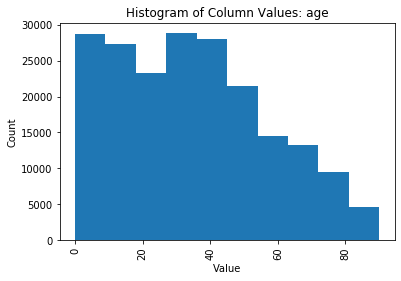

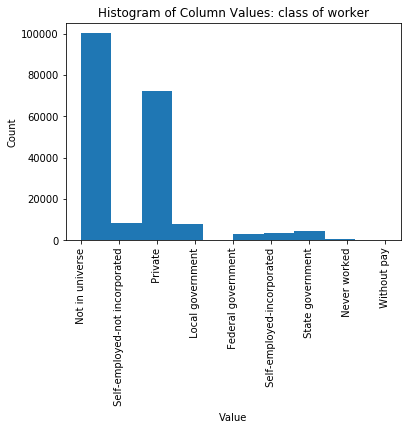

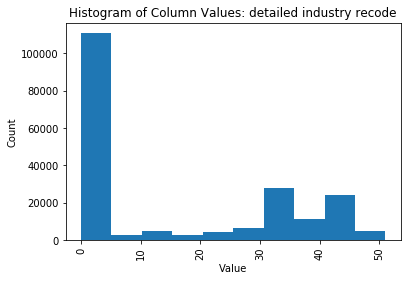

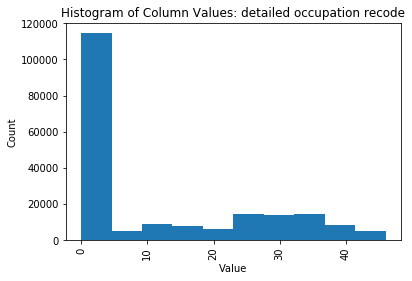

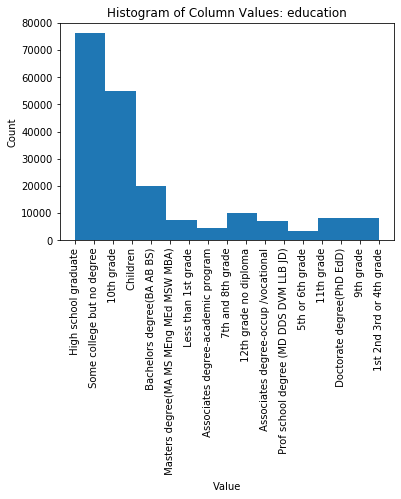

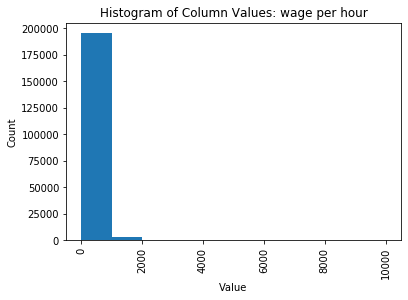

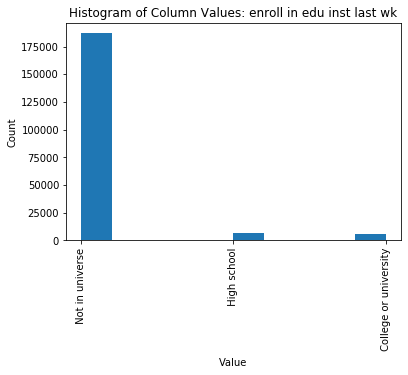

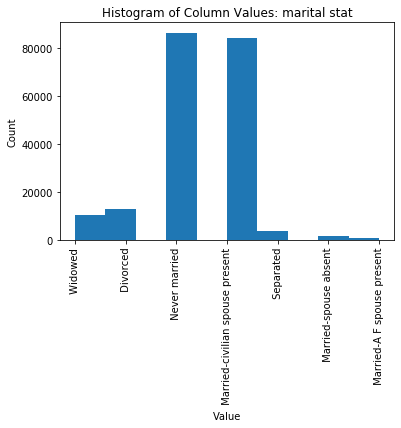

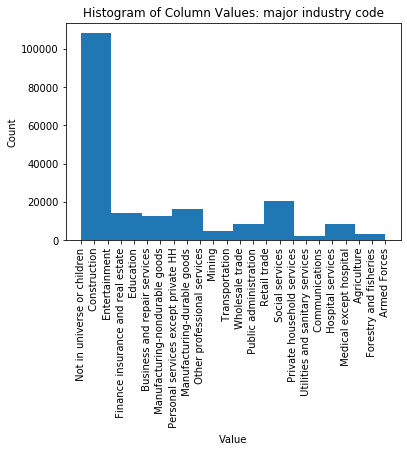

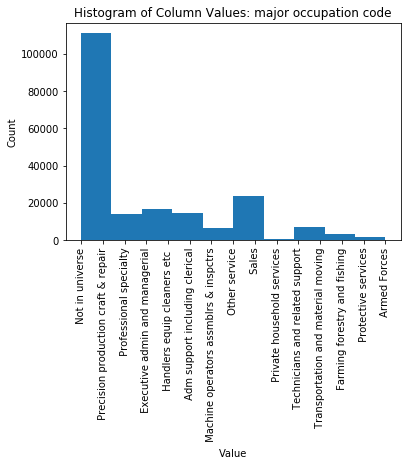

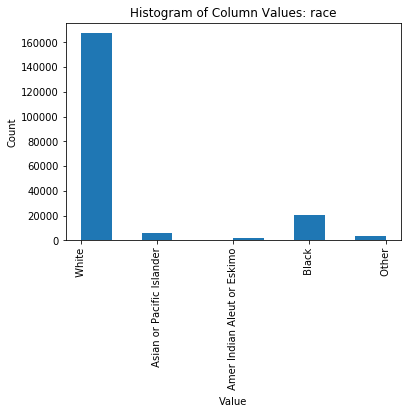

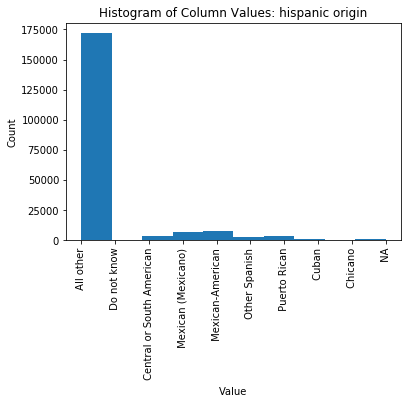

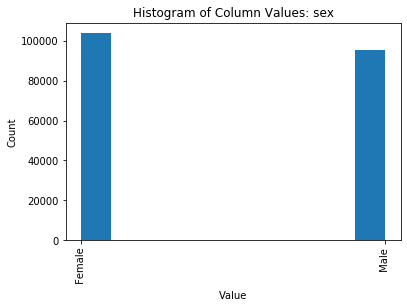

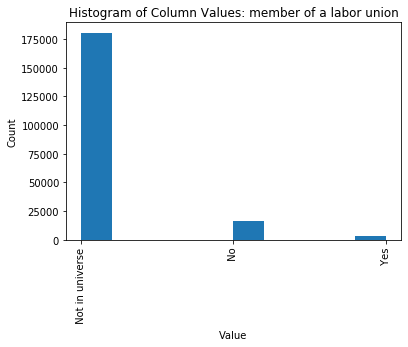

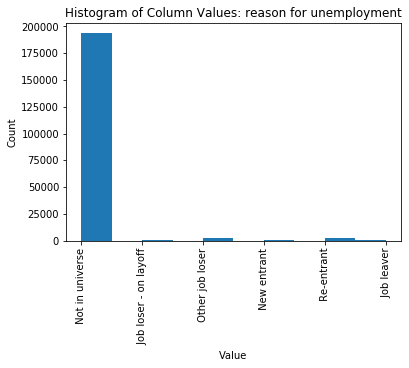

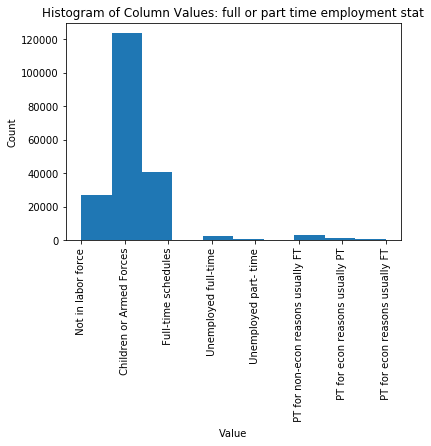

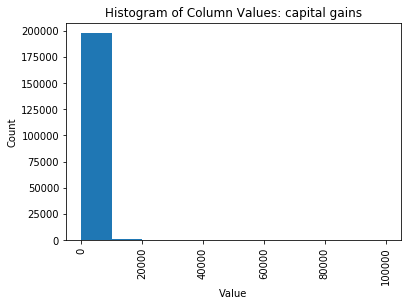

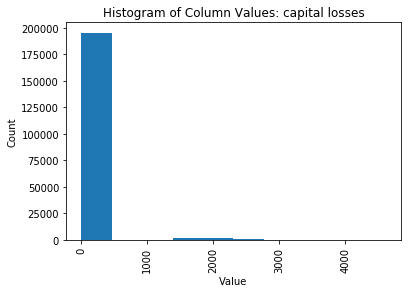

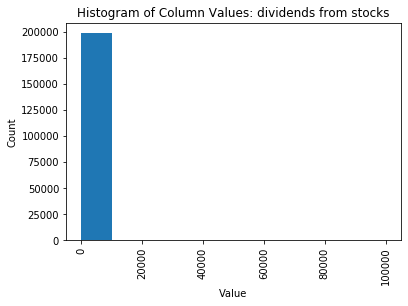

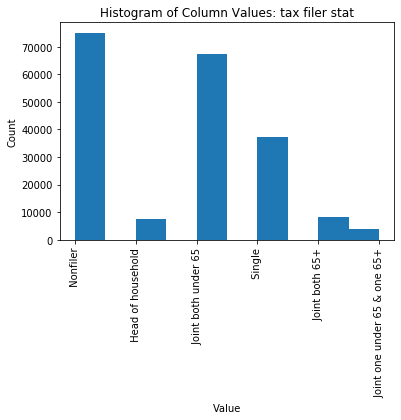

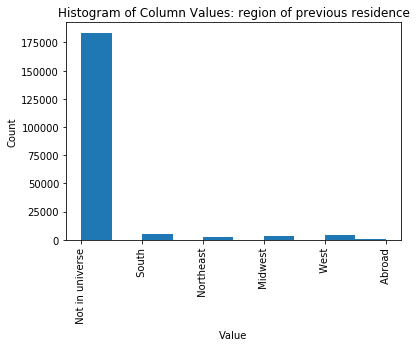

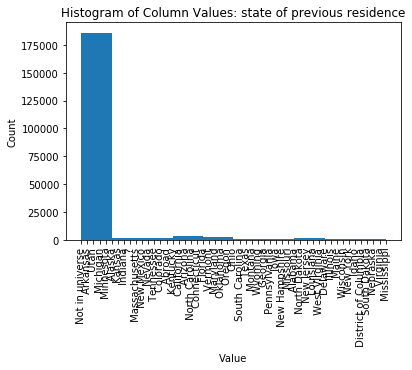

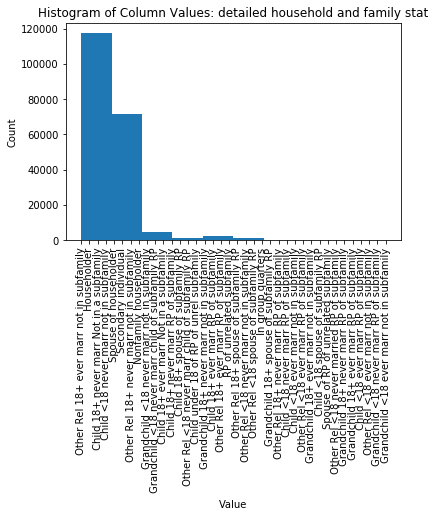

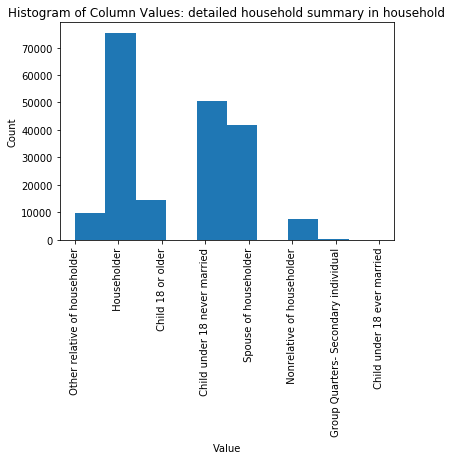

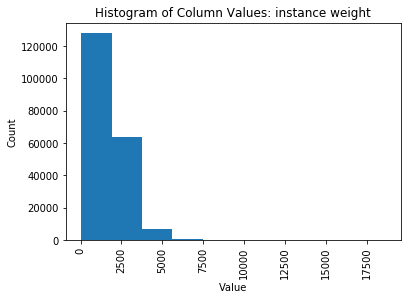

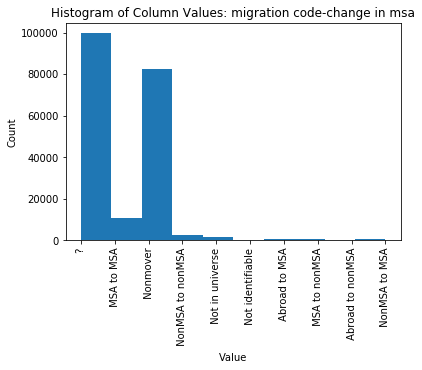

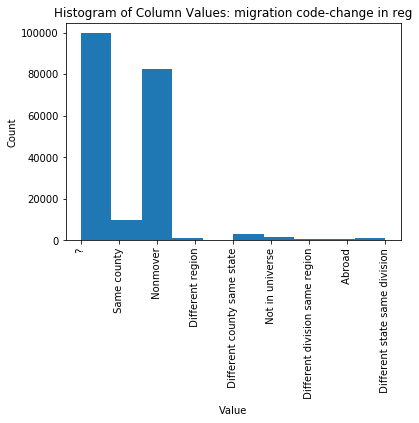

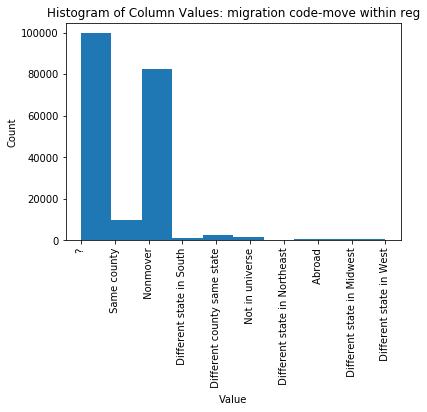

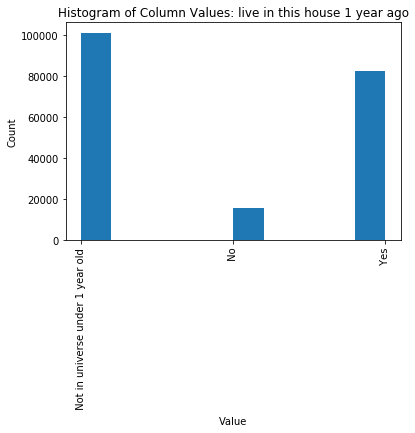

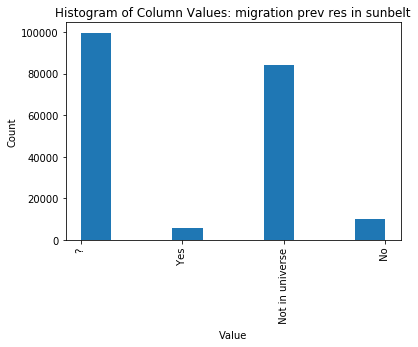

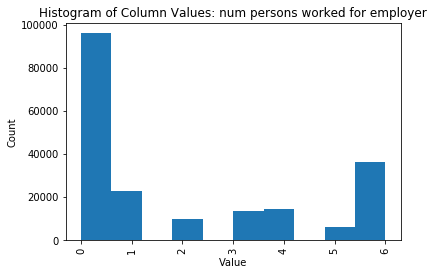

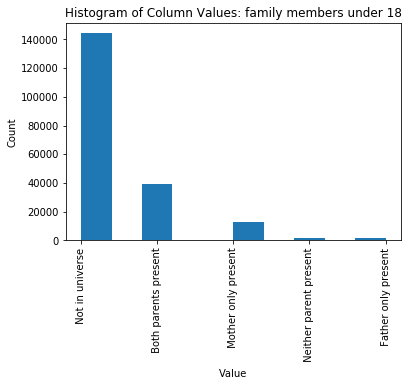

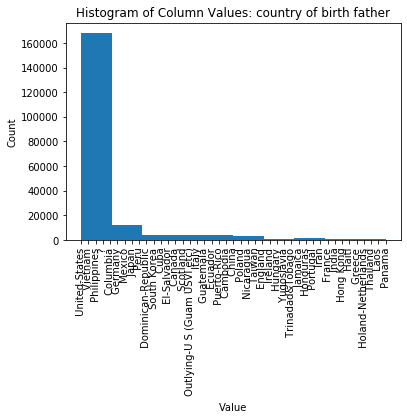

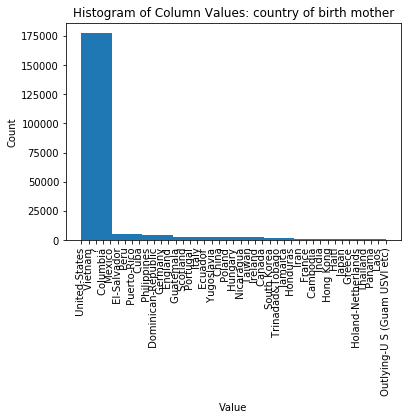

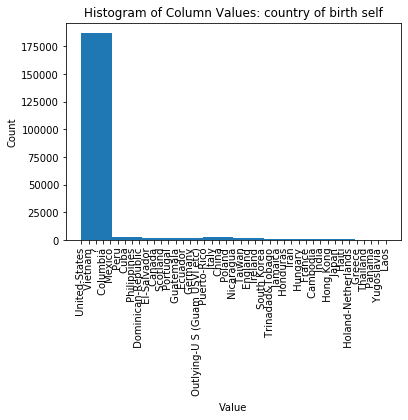

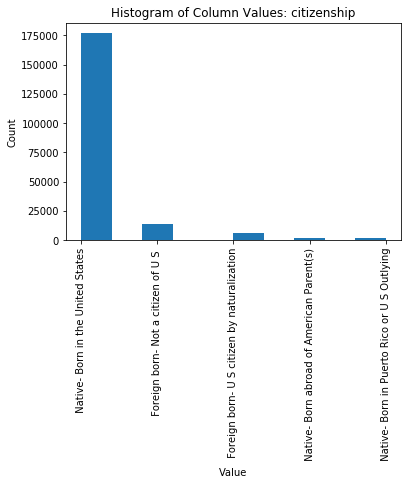

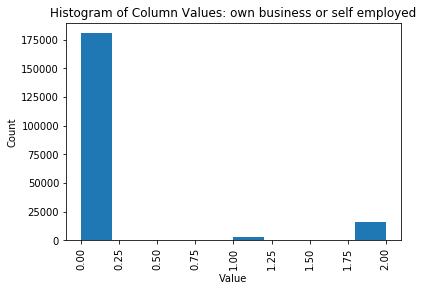

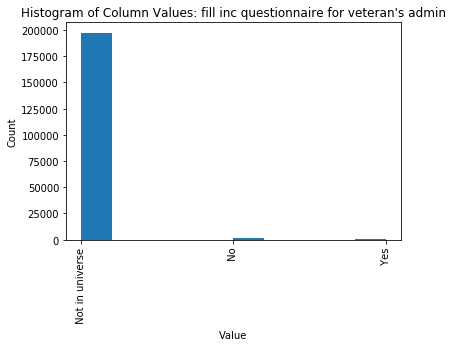

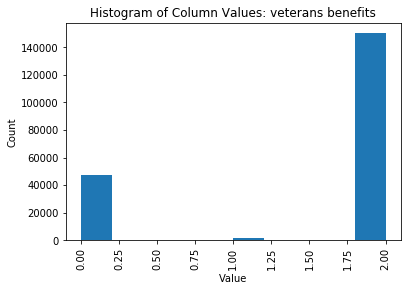

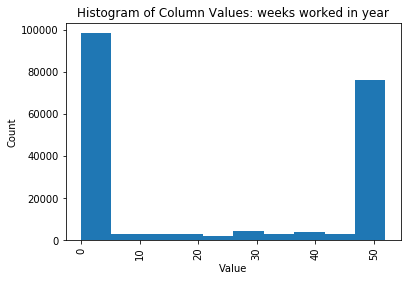

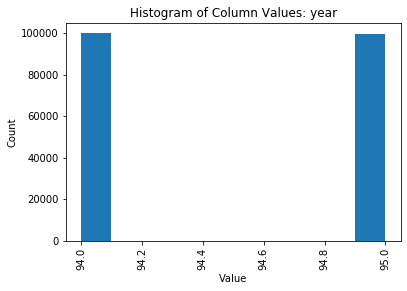

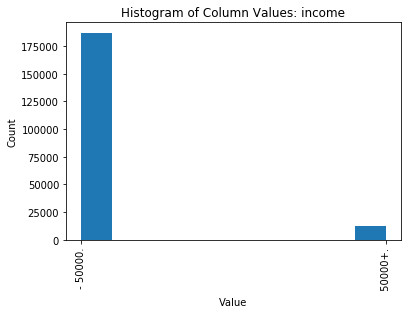

In [6]:
# 2.2) take a look at a histogram of counts of each unique value for each column -- lots of information, but manageable and good to digest in this case

for i in learn.columns:
    plt.figure()
    plt.title('Histogram of Column Values: {0}'.format(i))
    plt.ylabel('Count')
    plt.xlabel('Value')
    plt.xticks(rotation=90)
    plt.hist(learn[i])

#### Regarding above

There are some categorical variables like 'class of worker' and 'marital stat' that seem to be heavily skewed. However, given the large amount of samples and numerous columns, I'm not too concerned about them affecting the model's performance. Plus, I tend to lean on the side of "leaving data in/alone" and choosing a model to learn the nuances better, as opposed to "removing data/information". If it comes to be a problem later we will return and address it. But, I do not predict that will be so.

In [7]:
# 2.3) check for highly correlated numeric columns
corr = learn.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
age,1,0.157822,0.117414,0.0369383,0.0535903,0.0633514,0.104976,-0.00161058,0.140887,-0.00226549,0.674844,0.206181,0.00441349
detailed industry recode,0.157822,1,0.563493,0.16598,0.0660167,0.0725863,0.0127735,0.0293878,0.642096,0.252694,0.476475,0.754472,0.00342992
detailed occupation recode,0.117414,0.563493,1,0.194498,0.0025341,0.0436801,-0.0267262,0.0270471,0.515554,0.228952,0.43868,0.655613,-0.00313975
wage per hour,0.0369383,0.16598,0.194498,1,-0.001082,0.0109931,-0.00573099,0.0123534,0.191543,0.0540515,0.113094,0.195687,0.00228285
capital gains,0.0535903,0.0660167,0.0025341,-0.001082,1,-0.0127001,0.131476,0.0025486,0.058015,0.0150485,0.05153,0.083549,0.00524338
capital losses,0.0633514,0.0725863,0.0436801,0.0109931,-0.0127001,1,0.0424272,0.00805239,0.0842554,0.0241155,0.0753911,0.100762,9.57264e-05
dividends from stocks,0.104976,0.0127735,-0.0267262,-0.00573099,0.131476,0.0424272,1,-9.15048e-06,0.00720631,-0.00488458,0.0545845,0.0138231,0.00191267
instance weight,-0.00161058,0.0293878,0.0270471,0.0123534,0.0025486,0.00805239,-9.15048e-06,1,0.042778,0.0123284,0.0405067,0.0292397,0.0117648
num persons worked for employer,0.140887,0.642096,0.515554,0.191543,0.058015,0.0842554,0.00720631,0.042778,1,0.240553,0.463334,0.747302,0.0187738
own business or self employed,-0.00226549,0.252694,0.228952,0.0540515,0.0150485,0.0241155,-0.00488458,0.0123284,0.240553,1,0.177448,0.265872,0.00737711


#### Regarding above

The above matrix/heatmap is intended to look at whether there are any extremely highly correlated and potentially collinear columns in the dataset that may need to be dropped. I see a few that have *higher* correlation like `'weeks worked in year'` and `'num persons worked for employer'`, but the value of `0.747` is not quite high enough to be concerning. Again, we will press on.

## Step 3: Model the 42nd variable

In [8]:
learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

In [9]:
# 3.1) transform categorical variables to be one-hot encoded on both learn & test sets

# join for transformation, then unjoin later
num_learn_rows = learn.shape[0]
dataset = pd.concat([learn, test], axis=0)
categorical_variables = [col for col in dataset.columns if dataset[col].dtype == object and col != 'income']

# by-hand curation of categorical variables
categorical_variables += ['detailed industry recode', 'detailed occupation recode']

for cat_var in categorical_variables:
    # apply to dataset
    cat_var_df = pd.get_dummies(dataset[cat_var])
    cat_var_df = cat_var_df.add_prefix(cat_var+': ')
    
    # add new df to previous
    dataset.drop(columns=[cat_var], inplace=True)
    dataset = pd.concat([dataset, cat_var_df], axis=1)

# create new learn & test sets
new_learn = dataset[:num_learn_rows]
new_test = dataset[num_learn_rows:]

# get target values
one_hot_func = lambda elem: 1 if '+' in elem else 0
learn_y = new_learn.income.apply(one_hot_func)
test_y = new_test.income.apply(one_hot_func)
learn_x = new_learn.drop(columns=['income'])
test_x = new_test.drop(columns=['income'])

learn_x.head()

,age,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,...,detailed occupation recode: 37,detailed occupation recode: 38,detailed occupation recode: 39,detailed occupation recode: 40,detailed occupation recode: 41,detailed occupation recode: 42,detailed occupation recode: 43,detailed occupation recode: 44,detailed occupation recode: 45,detailed occupation recode: 46
0,73,0,0,0,0,1700.09,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,58,0,0,0,0,1053.55,1,0,2,52,...,0,0,0,0,0,0,0,0,0,0
2,18,0,0,0,0,991.95,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,1758.14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,1069.16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Regarding above

Before creating models to predict income, we need to transform the data a bit. Classifiers generally cannot work with values that are categorical like `'race'`. So, for the variables that are categorical we `one-hot encode` the column. This means that for the `N` distinct values, we create `N` new columns that are all indicator variables.

I also added a few more by hand that after reading the metadata file, I saw are both numeric & categorical. While the ones that are of type `object` can simply be inferred to be categorical. I cannot simply leave these as numeric because it will be misleading to the model. Saying `A` is `1` and `B` is `2` implies comparision and distance between the two that may or may not exist in reality. It is up to the model to decide, not us.

In [10]:
# 3.2) create simple logistic regression model

# create simple model & fit
log_reg = LogisticRegression()
log_reg.fit(learn_x, learn_y)

# predict with model & report findings
preds_log_reg = log_reg.predict(learn_x)
log_reg_prec, log_reg_recall, log_reg_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        learn_y, preds_log_reg, average='binary')

print('\n~~ LOGISTIC REGRESSION ~~')
print('Precision: {0}'.format(round(log_reg_prec, 4)))
print('   Recall: {0}'.format(round(log_reg_recall, 4)))
print('       F1: {0}'.format(round(log_reg_f1, 4)))


~~ LOGISTIC REGRESSION ~~
Precision: 0.7395
   Recall: 0.3784
       F1: 0.5006


In [11]:
# 3.3) create a simple decision tree model

# create simple model & fit
tree = DecisionTreeClassifier()
tree.fit(learn_x, learn_y)

# predict with model & report findings
preds_tree = tree.predict(learn_x)
tree_prec, tree_recall, tree_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        learn_y, preds_tree, average='binary')

print('\n~~ DECISION TREE ~~')
print('Precision: {0}'.format(round(tree_prec, 4)))
print('   Recall: {0}'.format(round(tree_recall, 4)))
print('       F1: {0}'.format(round(tree_f1, 4)))


~~ DECISION TREE ~~
Precision: 1.0
   Recall: 0.9999
       F1: 1.0


#### Regarding above

We have created two models! Yay! And wow! We got 100% Precision on the Decision Tree. Must be the better model, right? Are we done?

NO! We essentially just passed out both the test and the answer sheet to the Decision Tree! And because it is essentially overfitting to the learn set (by nature of the model) it can perform perfectly on the learn set. It is truly an unfair comparison. The logistic regression model is, by nature, not flexible enough to contain that much variance, and thus does not overfit in this way.

Let's redo this experiment, but let's split `80% / 20%` train/validation, so that we have some data the "trained" model hasn't seen before. This should: 1) enable us to have a fair comparision before choosing a model, 2) keep the `test` set unseen completely. Lock it away in a box and swallow the key, as they say!

In [12]:
# 3.4) split learn into: train & validate sets

# get validate sets: 80% train, 20% validate
learn_mask = np.random.rand(len(new_learn)) < 0.8
train = new_learn[learn_mask]
validate = new_learn[~learn_mask]

train_y = train.income.apply(one_hot_func)
validate_y = validate.income.apply(one_hot_func)
train_x = train.drop(columns=['income'])
validate_x = validate.drop(columns=['income'])

train_x.shape, validate_x.shape

((159809, 506), (39714, 506))

In [13]:
print('RESULTS ON VALIDATION SET:')

# 3.5) generate new models

# logistic regression
log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)

# predict with model & report findings with VALIDATION set
preds_log_reg = log_reg.predict(validate_x)
log_reg_prec, log_reg_recall, log_reg_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        validate_y, preds_log_reg, average='binary')

print('\n~~ LOGISTIC REGRESSION ~~')
print('Precision: {0}'.format(round(log_reg_prec, 4)))
print('   Recall: {0}'.format(round(log_reg_recall, 4)))
print('       F1: {0}'.format(round(log_reg_f1, 4)))

# decision tree
tree = DecisionTreeClassifier()
tree.fit(train_x, train_y)

# predict with model & report findings with VALIDATION set
preds_tree = tree.predict(validate_x)
tree_prec, tree_recall, tree_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        validate_y, preds_tree, average='binary')

print('\n~~ DECISION TREE ~~')
print('Precision: {0}'.format(round(tree_prec, 4)))
print('   Recall: {0}'.format(round(tree_recall, 4)))
print('       F1: {0}'.format(round(tree_f1, 4)))

RESULTS ON VALIDATION SET:

~~ LOGISTIC REGRESSION ~~
Precision: 0.7135
   Recall: 0.3797
       F1: 0.4956

~~ DECISION TREE ~~
Precision: 0.4619
   Recall: 0.4829
       F1: 0.4722


#### Regarding above

Aha! Just what we suspected. The Decision Tree "learned" the training set so well that it could not generalize to new data. The logistic regrssion model, however, received approximately the same scores on both the learn and the validation set.

It seems in this case like the logistic regression model is the way to go! We will, just for reference, also run the test set through the decision tree model, to validate this result.

## Step 4: Apply model(s) to test file

In [14]:
print('RESULTS ON TEST SET:')

# 4.1) logistic regression

# predict with model & report findings with TEST set
preds_log_reg = log_reg.predict(test_x)
log_reg_prec, log_reg_recall, log_reg_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_y, preds_log_reg, average='binary')

print('\n~~ LOGISTIC REGRESSION ~~')
print('Precision: {0}'.format(round(log_reg_prec, 4)))
print('   Recall: {0}'.format(round(log_reg_recall, 4)))
print('       F1: {0}\n'.format(round(log_reg_f1, 4)))

# 4.2) decision tree

# predict with model & report findings with TEST set
preds_tree = tree.predict(test_x)
tree_prec, tree_recall, tree_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_y, preds_tree, average='binary')

print('\n~~ DECISION TREE ~~')
print('Precision: {0}'.format(round(tree_prec, 4)))
print('   Recall: {0}'.format(round(tree_recall, 4)))
print('       F1: {0}'.format(round(tree_f1, 4)))

RESULTS ON TEST SET:

~~ LOGISTIC REGRESSION ~~
Precision: 0.7429
   Recall: 0.3876
       F1: 0.5095


~~ DECISION TREE ~~
Precision: 0.4642
   Recall: 0.4956
       F1: 0.4794


#### Regarding above

Alas, the logistic regression model faired similarly on the `test` set as well! And, as an added bonus, it performed significantly better than our decision tree, further verifying our previous model conclusion/choice. Now let's move on to what this actually means to us outside of these numbers.

## Step 5: Further discussion

In this step we will attempt to understand the model a bit more and suggest some "next steps" that could be taken.

In [17]:
# 5.1) find most important coefficients

coefficients = log_reg.coef_[0]
top_indices = coefficients.argsort()[-4:][::-1]
top_coeffs_sorted = train_x.columns[top_indices]

for idx in top_indices:
    print(round(coefficients[idx], 4), ' ---- ', train_x.columns[idx])

1.5267  ----  education:  Doctorate degree(PhD EdD)
1.3923  ----  education:  Prof school degree (MD DDS DVM LLB JD)
1.1621  ----  education:  Masters degree(MA MS MEng MEd MSW MBA)
0.8519  ----  major occupation code:  Professional specialty


#### Regarding above

Well, perhaps somewhat surprisingly, perhaps not, it seems like the most likely predictors of whether a person makes over 50000 USD or not is, in order:

  1. if they hold a doctorate degree
  2. if they hold a professional degree
  3. if they hold a master's degree
  4. if they work in a professional specialty

In [18]:
# 5.2) next steps discussion

The dataset itself contains many opportunities for tweaking. After performing `one-hot encoding` we were left with 500+ columns. Many or most of these may have been able to be dropped, and that call could have been made with further analysis. Luckily, we had no missing values. However, we did not perform too much analysis on any outliers and how that may have affected our results. Next steps would surely include this.

The model selection process itself contains a great deal of options. We chose two very simple models for the sake of the process simplicity laid out here, but we certainly could have experimented more. SVMs, Random Forests, Naive Bayes, and KNNs would have been a good place to start. Each has its own strengths/weaknesses and through experimentation we have the opportunity to both learn more about the dataset itself and how to better choose a model.

Lastly, in whatever is chosen, an thorough explanation of the results is merited. One deserves to know "why" the model selected certain results, how to interpret that, and what to do with that. For example, in this case, ought we say `"You over there! If you want to make money someday, you had better get a master's degree!"` Clearly not! The model and its outcomes can tell us specifically and exactly what we trained it to. Nothing more. In this case, we have a model that can predict which half of the income world a person with certain characteristics is most likely to fall. However, there is a great deal left to be desired in the description and explanation of that result.

## Step 6: Personal discussion

Data cleaning and pre-processing is typically the most challenging area for me.

* What do you do with missing values?
* What do you do with sparse data?
* What do you do with outliers?
* What do you do with heavily skewed features?
* What do you do with underrepresented categories?

The reason this is so difficult for me is that the answers to the above questions *vastly* change the type of model you end up with, and vice-versa. A neural network can learn to deal with outliers in many cases. But can KNNs? Can Logistic Regresssion? All of these questions need to be answered. Do we need to bootstrap? Do we need to oversample? What about undersample? The questions to these affect the model choice, and the model choice affects the cleaning/preprocessing. The intertwined nature of the two, as we alter the training space, is difficult to balance and one can never be 100% sure of their results. Only sufficiently confident. And soon thereafter, they must re-validate.